In [1]:
%matplotlib inline
import pylab as pl
from astropy.io import fits
import numpy as np
from astropy import units as u

# Load the data

In [2]:
ne_image = fits.getdata('data/Light_neon17.50mm_1sec_Bin2_0.0C_gain0_2024-09-03_105405_frame0001.fit')
solar_image = fits.getdata('data/Light_sun17.50mm_5sec_Bin2_-0.3C_gain0_2024-09-03_104925_frame0001.fit')

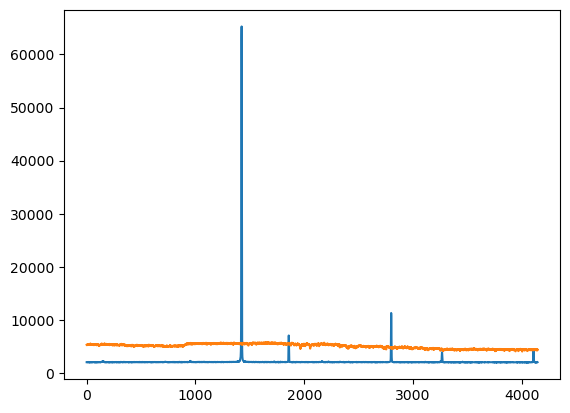

In [3]:
ne_spectrum = ne_image[1200,:]
pl.plot(ne_spectrum)
pl.plot(solar_image[1200, :]);

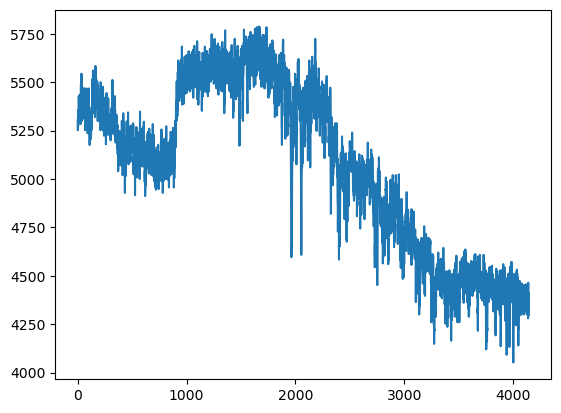

In [4]:
pl.plot(solar_image[1200, :]);

# Input initial guesses

In [5]:
guesspix = np.array([1862, 2800, 1419, 3267, 2163, 2223, 948, 146, 4104])
guess_wl = np.array([5881.895, 5944.834, 5852.488, 5975.534, 5902.462, 5906.429, 5820.156, 5764.419, 6029.997])
xaxis = np.arange(ne_image.shape[1])

## Fit initial guesses

In [6]:
from astropy.modeling.fitting import LinearLSQFitter
linfitter = LinearLSQFitter()

In [7]:
from astropy.modeling.models import Linear1D
wlmodel = Linear1D()
linfit_wlmodel = linfitter(model=wlmodel, x=guesspix, y=guess_wl)
wavelengths = linfit_wlmodel(xaxis) * u.AA
linfit_wlmodel

<Linear1D(slope=0.06705376, intercept=5756.52802246)>

## Improve guesses

In [8]:
npixels = 15
improved_xval_guesses = np.array([np.average(xaxis[g-npixels:g+npixels],
                                             weights=ne_spectrum[g-npixels:g+npixels] - np.median(ne_spectrum))
                                  for g in guesspix])
improved_xval_guesses

array([1856.95913574, 2798.50905449, 1423.39267143, 3264.48584906,
       2163.14402174, 2222.45061728,  951.51896208,  148.18491921,
       4106.05063727])

In [9]:
linfit_wlmodel = linfitter(model=wlmodel, x=improved_xval_guesses, y=guess_wl)
wavelengths = linfit_wlmodel(xaxis) * u.AA
linfit_wlmodel

<Linear1D(slope=0.06711112, intercept=5756.38726087)>

## Plot fit & residual

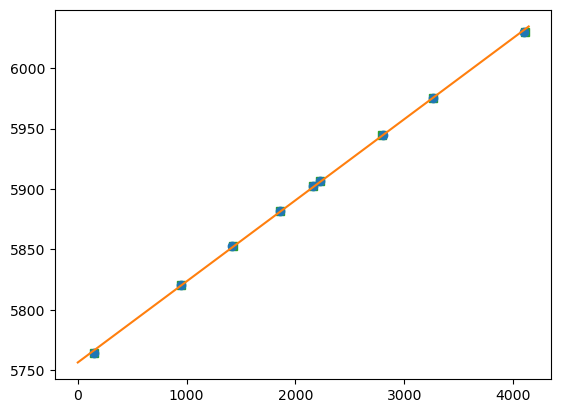

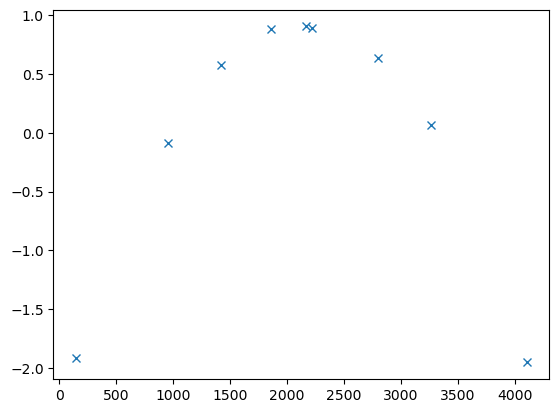

In [10]:
pl.plot(guesspix, guess_wl, 'o')
pl.plot(xaxis, wavelengths, '-')
pl.plot(improved_xval_guesses, guess_wl, 's', zorder=-5)
pl.figure()
pl.plot(improved_xval_guesses, (guess_wl - linfit_wlmodel(improved_xval_guesses)), 'x')

## Refit with higher order

In [11]:
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.fitting import LinearLSQFitter

In [12]:
# We fit a 2rd-order polynomial
polymodel = Polynomial1D(degree=2)
linfitter = LinearLSQFitter()
fitted_polymodel = linfitter(polymodel, improved_xval_guesses, guess_wl)
wavelengths = fitted_polymodel(xaxis) * u.AA

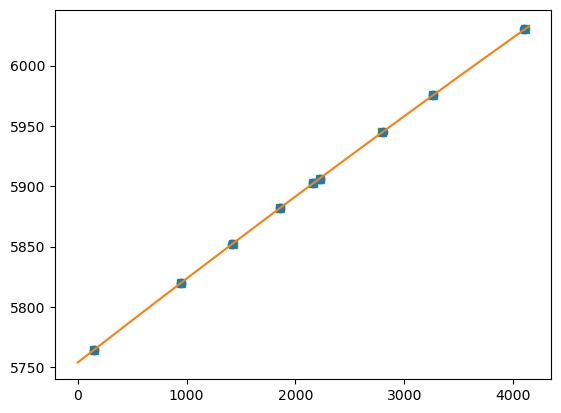

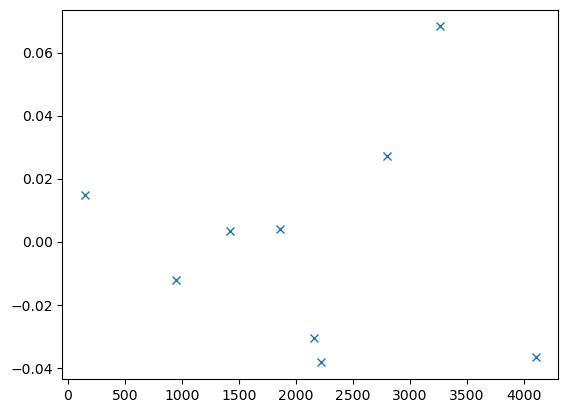

In [13]:
pl.plot(guesspix, guess_wl, 'o')
pl.plot(xaxis, fitted_polymodel(xaxis), '-')
pl.plot(improved_xval_guesses, guess_wl, 's', zorder=-5)
pl.figure()
pl.plot(improved_xval_guesses, (guess_wl - fitted_polymodel(improved_xval_guesses)), 'x')

### Equivalently, we can do this with WavelengthCalibration1D

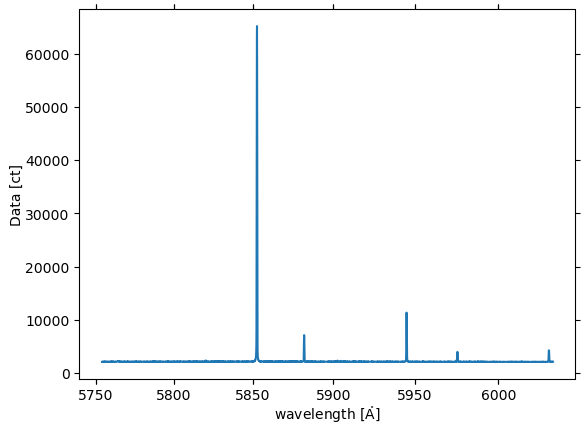

In [14]:
from specreduce import WavelengthCalibration1D
from specutils import Spectrum1D
spectrum_to_calibrate = Spectrum1D(flux=u.Quantity(ne_spectrum, u.count))
inds = np.argsort(guesspix)
wlcal = WavelengthCalibration1D(spectrum_to_calibrate,
                                line_pixels=improved_xval_guesses[inds],
                                line_wavelengths=guess_wl[inds]*u.AA,
                                input_model=Polynomial1D(degree=2),
                               )
wlcal.apply_to_spectrum(spectrum_to_calibrate).plot();

## Let's do some peakfinding

In [73]:
from scipy.signal import find_peaks

25

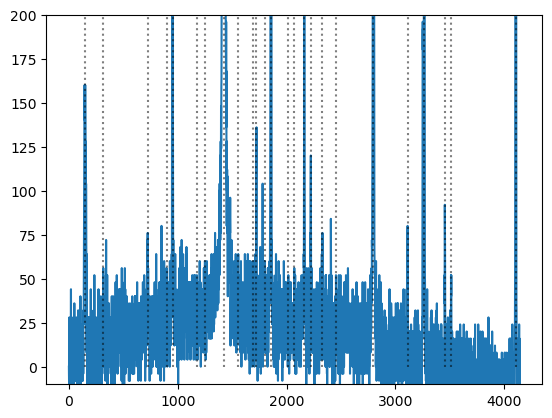

In [119]:
# background-subtract first
ne_spectrum_bgsub = ne_spectrum - np.percentile(ne_spectrum, 20)
locs, props = find_peaks(ne_spectrum_bgsub, height=50, prominence=15, distance=15, width=4)
pl.plot(ne_spectrum_bgsub)
pl.vlines(locs, 0, 5000, color='k', linestyle=':', alpha=0.5)
pl.ylim(-10,200);
#pl.axis([1200,1600,-10, 500]);
#pl.axis([3200,3600,-10, 150]);
#pl.axis([2300,2600,-10, 150]);
len(locs)

In [124]:
# predict wavelengths
predicted_wls = fitted_polymodel(locs)

# Query line catalog

In [15]:
from astroquery.nist import Nist
minwave = wavelengths.min()
maxwave = wavelengths.max()
neon_lines = Nist.query(minwav=minwave,
                        maxwav=maxwave,
                        wavelength_type='vac+air',
                        linename='Ne I')

In [16]:
neon_lines.pprint(max_lines=40, max_width=1000);

 Observed    Ritz   Transition  Rel.    Aki       fik    Acc.       Ei           Ek                    Lower level                         Upper level             gi   gk Type   TP   Line
--------- --------- ---------- ----- ---------- -------- ---- ---------------------------- ----------------------------------- ----------------------------------- ------- ---- ----- -----
5760.5885 5760.5882 17354.5243   700   506000.0   0.0018   C+ 18.55510805  -   20.70679493 2s2.2p5.(2P*<3/2>).3p | 2[5/2]  | 3 2s2.2p5.(2P*<3/2>).4d | 2[3/2]* | 2   7 - 5   -- T6976 L3451
5764.0525  5764.053  17344.095    30   550000.0  0.00274   C+ 18.55510805  -   20.70550158 2s2.2p5.(2P*<3/2>).3p | 2[5/2]  | 3 2s2.2p5.(2P*<3/2>).4d | 2[7/2]* | 3   7 - 7   -- T6976 L4498
5764.4188 5764.4189 17342.9928  7000 11200000.0   0.0717    B 18.55510805  -   20.70536507 2s2.2p5.(2P*<3/2>).3p | 2[5/2]  | 3 2s2.2p5.(2P*<3/2>).4d | 2[7/2]* | 4   7 - 9   -- T6976 L3451
5770.3067 5770.3132  17325.297   500   404000.0  0.00606   C

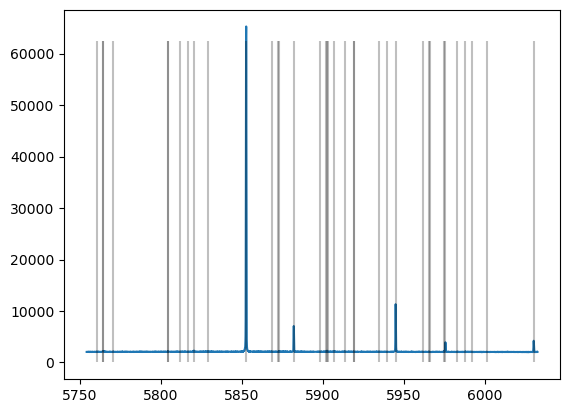

In [17]:
pl.plot(wavelengths, ne_spectrum)
pl.vlines(neon_lines['Observed'], 0, 62500, 'k', alpha=0.25)

## Downselect bright lines

In [18]:
# these lines downselect from the table to keep only those that have usable "Relative Intensity" measurements
# first, we get rid of those whose 'Rel.' column is masked out or is an asterisk
ne_keep = (neon_lines['Rel.'] != "*")
ne_wl_tbl = neon_lines['Observed'][ne_keep]
# then, we collect the 'Rel.' values and convert them from strings to floats
ne_rel_tbl = np.array([float(x) for x in neon_lines['Rel.'][ne_keep]])
ne_rel_intens = ne_rel_tbl / ne_rel_tbl.max() * ne_spectrum.max()

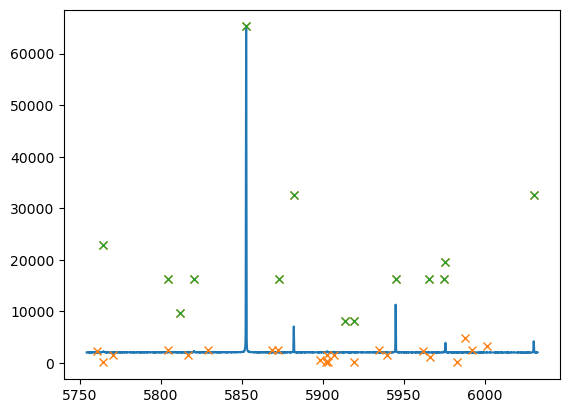

In [19]:
pl.plot(wavelengths, ne_spectrum)
# we normalize the relative intensities to match the intensity of the spectrum so we can see both on the same plot
# since they're just relative intensities, their amplitudes are arbitrary anyway
pl.plot(ne_wl_tbl, ne_rel_intens, 'x')
ne_keep_2 = ne_rel_intens > 5000
pl.plot(ne_wl_tbl[ne_keep_2], ne_rel_intens[ne_keep_2], 'x')

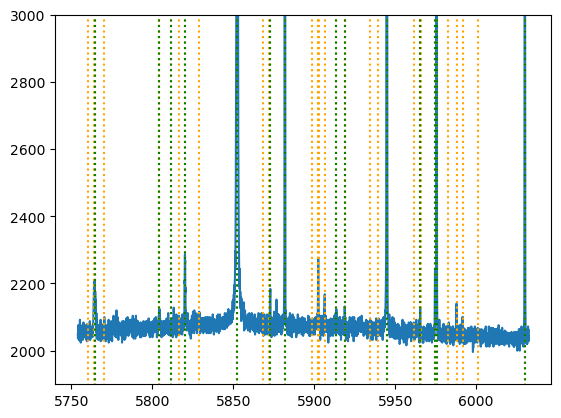

In [20]:
pl.plot(wavelengths, ne_spectrum)
# we normalize the relative intensities to match the intensity of the spectrum so we can see both on the same plot
# since they're just relative intensities, their amplitudes are arbitrary anyway
pl.vlines(ne_wl_tbl, 0, 60000, color='orange', linestyle=':')
pl.vlines(ne_wl_tbl[ne_keep_2], 0, 60000, color='g', linestyle=':')
pl.ylim([1900, 3000]);

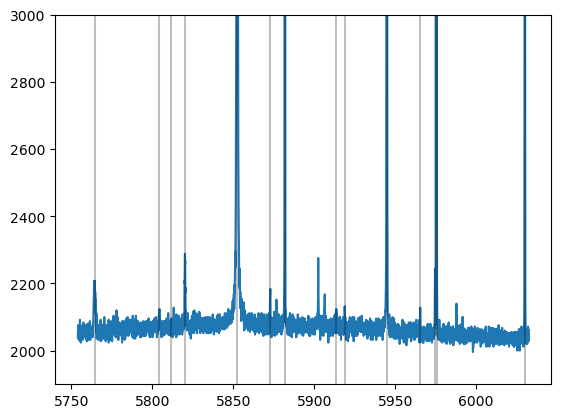

In [21]:
ne_spectrum = ne_image[1200,:]
pl.plot(wavelengths, ne_spectrum)
pl.vlines(neon_lines['Observed'][ne_keep_2], 0, 62500, 'k', alpha=0.25)
pl.ylim(1900, 3000);

## Downselect to lines found via peakfinding

In [121]:
from scipy.spatial import KDTree

In [129]:
kt = KDTree(np.transpose([neon_lines['Observed'][ne_keep]]))
kt.query(predicted_wls[:,None])

(array([1.12473085e-01, 5.82428961e+00, 2.06938282e-02, 2.08509475e-01,
        4.53808847e-02, 6.67592732e+00, 1.17410790e+01, 3.80509857e-02,
        6.90886026e+00, 1.34223640e+00, 7.03739605e-03, 3.98677289e+00,
        1.23772758e-03, 5.71954405e+00, 2.02154751e+00, 2.07264277e-02,
        7.47172855e-02, 2.90272612e-02, 2.90727955e+00, 6.07863652e-02,
        3.16826664e-03, 3.49082378e-02, 6.32343903e-02, 9.07363682e-02,
        3.35628521e-02]),
 array([ 2,  3,  5,  7,  8,  9,  9, 10, 11, 12, 13, 14, 14, 15, 15, 17, 19,
        20, 22, 25, 27, 30, 32, 33, 35]))

## Convert bright lines to pixel predictions

In [22]:
def inverse_polymodel(wl, xaxis=xaxis, wavelengths=wavelengths):
    return np.interp(wl, wavelengths, xaxis)

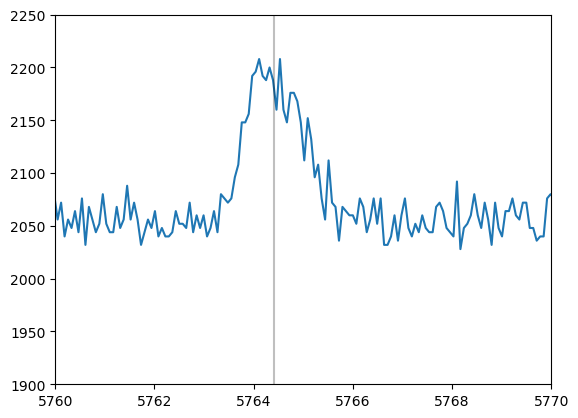

In [23]:
ne_spectrum = ne_image[1200,:]
pl.plot(wavelengths, ne_spectrum)
pl.vlines(neon_lines['Observed'][ne_keep_2], 0, 62500, 'k', alpha=0.25)
pl.ylim(1900, 2250);
pl.xlim(5760, 5770);

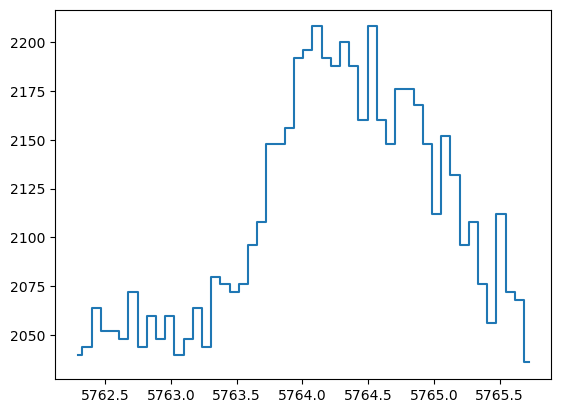

In [24]:
pl.plot(wavelengths[143-25:143+25], ne_spectrum[143-25:143+25], drawstyle='steps-mid');

In [25]:
# measure s/n for each....
from astropy import stats
ne_wl_final = []
ne_keep_final = np.zeros(len(ne_wl_tbl), dtype='bool')
for ii, wl in enumerate(ne_wl_tbl):
    pixcen = int(inverse_polymodel(wl*u.AA))
    data = ne_spectrum[pixcen-35:pixcen+35]
    data_bl = data - np.percentile(data, 10)
    rms = stats.mad_std(data_bl)
    peak = data_bl.max()
    sn = peak / rms
    if sn > 4:
        print(wl, pixcen, sn)
        ne_wl_final.append(wl)
        ne_keep_final[ii] = True
ne_wl_final = u.Quantity(ne_wl_final, u.AA)

5764.0525 143 4.254473808929131
5764.4188 148 4.04693850117649
5804.4496 723 4.04693850117649
5811.4066 824 6.407652626862776
5816.6219 900 4.417907863784342
5820.1558 951 18.885713005490288
5852.4878 1423 304.15826218056503
5872.145 1712 7.217040327098079
5872.8275 1722 7.217040327098079
5881.895 1857 241.6600419273961
5898.3287 2101 4.384183376274531
5902.0944 2157 9.105611627647102
5902.4623 2162 9.105611627647102
5902.7835 2167 9.105611627647102
5906.4294 2221 6.295237668496762
5918.9068 2408 5.665713901647086
5919.029 2410 5.665713901647086
5939.3154 2715 4.04693850117649
5944.834 2798 240.2221187236814
5961.6228 3053 4.384183376274531
5965.471 3112 5.395918001568654
5966.179 3122 5.395918001568654
5974.6273 3251 79.43803032934352
5975.5343 3265 63.536934468470896
5982.3753 3370 4.417907863784342
5987.9074 3454 6.070407751764735
5991.6477 3512 4.069421492849698
6029.9968 4105 123.43162428588295


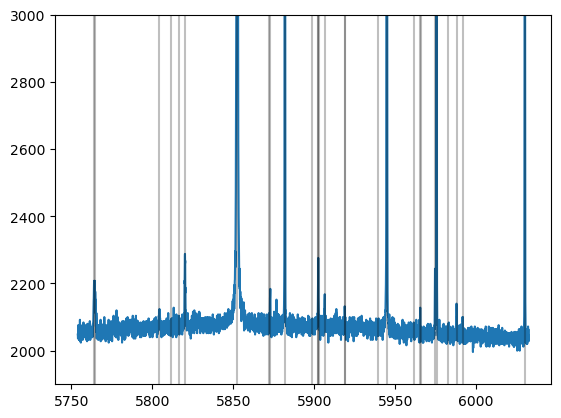

In [26]:
ne_spectrum = ne_image[1200,:]
pl.plot(wavelengths, ne_spectrum)
pl.vlines(ne_wl_final, 0, 62500, 'k', alpha=0.25)
pl.ylim(1900, 3000);

In [27]:
# select down to just those lines we want to keep
#ne_wl_final = ne_wl_tbl[ne_keep_final]
# linear isn't good enough.  ne_pixel_vals = linfit_wlmodel.inverse(ne_wl_final)
ne_pixel_vals = inverse_polymodel(ne_wl_final)

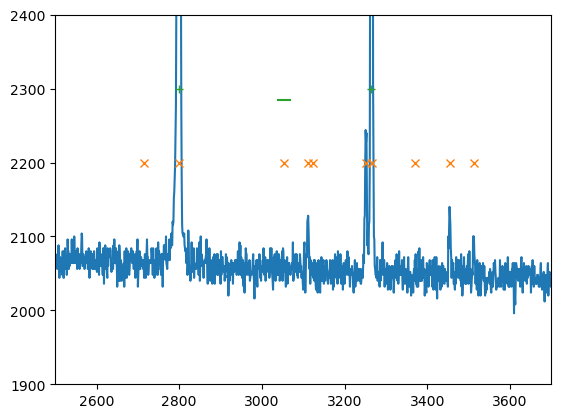

In [28]:
# check for overlaps again (in the densest part of the spectrum)
pl.plot(xaxis, ne_spectrum)
pl.plot(ne_pixel_vals, [2200]*len(ne_pixel_vals), 'x')
pl.plot(improved_xval_guesses, [2300] * len(improved_xval_guesses), '+')
for xx, yy in zip(ne_pixel_vals, ne_rel_intens[ne_keep_final]):
    pl.plot([xx-15,xx+15], [yy,yy], )
pl.xlim(2500, 3700)
pl.ylim(1900, 2400);

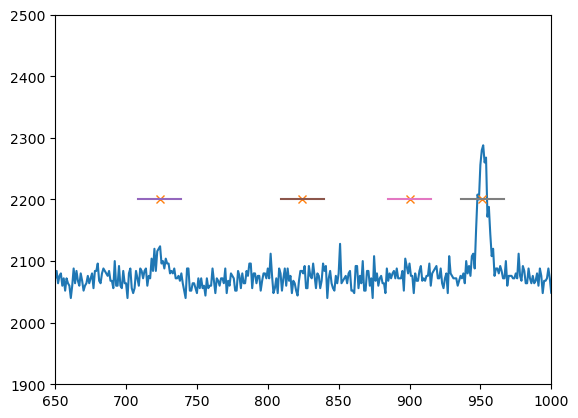

In [29]:
# check for overlaps again (in the densest part of the spectrum)
pl.plot(xaxis, ne_spectrum)
pl.plot(ne_pixel_vals, [2200]*len(ne_pixel_vals), 'x')
for xx, yy in zip(ne_pixel_vals, ne_rel_intens[ne_keep_final]):
    pl.plot([xx-15,xx+15], [2200, 2200], )
pl.xlim(650,1000)
pl.ylim(1900, 2500);

## Measure bright line pixel locations

In [30]:
npixels = 10
improved_xval_guesses_ne = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=ne_spectrum[g-npixels:g+npixels] - np.median(ne_spectrum))
                         for g in map(int, ne_pixel_vals)]
improved_xval_guesses_ne

[145.04634146341462,
 147.41980198019803,
 723.4573643410853,
 830.05,
 899.0652173913044,
 951.6221294363256,
 1423.497135292089,
 1717.234375,
 1722.1472081218274,
 1856.8768309970073,
 2103.176470588235,
 2161.4523809523807,
 2162.918429003021,
 2164.2245508982037,
 2221.3658536585367,
 2408.6315789473683,
 2405.875,
 2705.076923076923,
 2798.5041188822483,
 3053.40350877193,
 3109.0285714285715,
 3134.3714285714286,
 3253.439330543933,
 3265.169099756691,
 3368.0,
 3470.4,
 3510.54,
 4105.942521008404]

## Refit with line list

In [31]:
refitted_polymodel = linfitter(polymodel, improved_xval_guesses_ne, ne_wl_final.value)
wavelengths_refit = refitted_polymodel(xaxis) * u.AA

In [140]:
refitted_polymodel

<Polynomial1D(2, c0=5753.88726259, c1=0.07036297, c2=-0.00000077)>

In [35]:
np.mean(np.diff(wavelengths_refit))

<Quantity 0.06717657 Angstrom>

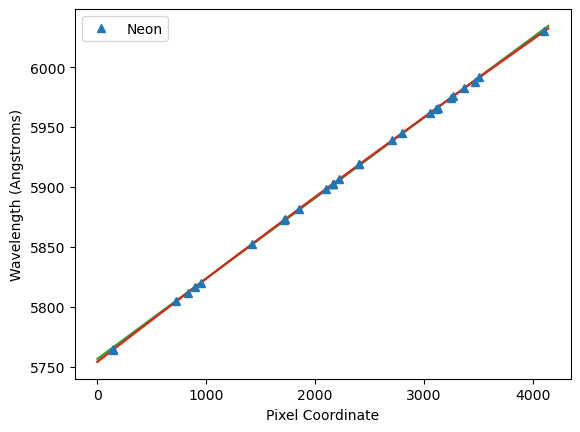

In [32]:
pl.plot(improved_xval_guesses_ne, ne_wl_final, '^', label='Neon')
pl.plot(xaxis, wavelengths_refit, zorder=-5)
pl.plot(xaxis, linfit_wlmodel(xaxis), zorder=-5)
pl.plot(xaxis, fitted_polymodel(xaxis), zorder=-5)
pl.legend(loc='best')
pl.xlabel("Pixel Coordinate")
pl.ylabel("Wavelength (Angstroms)");

Text(0, 0.5, 'Wavelength residual (data minus model; nm)')

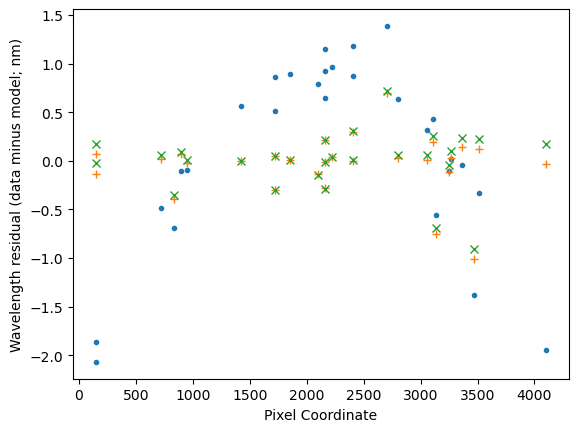

In [33]:
pl.plot(improved_xval_guesses_ne, ne_wl_final.value - linfit_wlmodel(improved_xval_guesses_ne), '.')
pl.plot(improved_xval_guesses_ne, ne_wl_final.value - fitted_polymodel(improved_xval_guesses_ne), '+')
pl.plot(improved_xval_guesses_ne, ne_wl_final.value - refitted_polymodel(improved_xval_guesses_ne), 'x')
pl.xlabel("Pixel Coordinate")
pl.ylabel("Wavelength residual (data minus model; nm)")

# Plot final wavelength solution

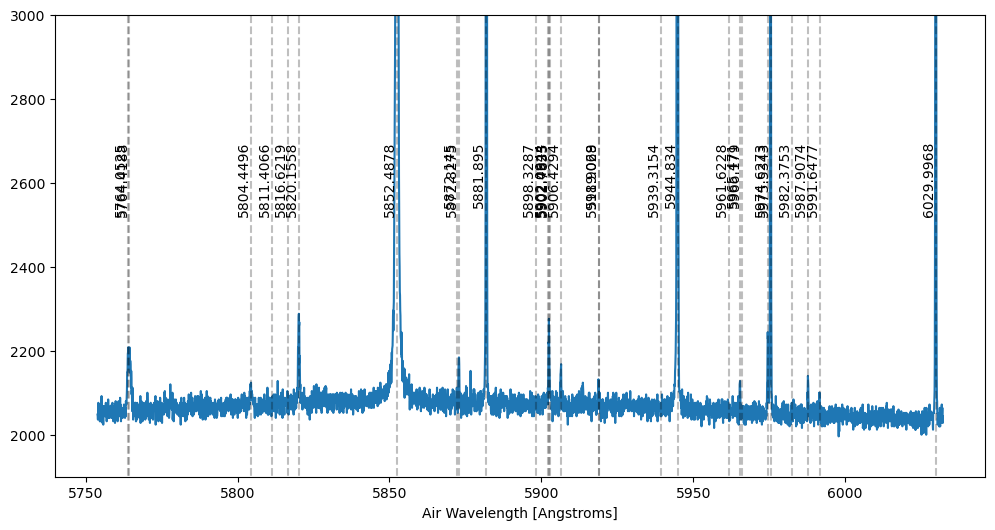

In [34]:
pl.figure(figsize=(12, 6))
pl.plot(wavelengths_refit, ne_spectrum)
pl.vlines(neon_lines['Observed'][ne_keep_final], 0, 62500, 'k', alpha=0.25, linestyle='--')
for wl in neon_lines['Observed'][ne_keep_final]:
    pl.text(wl, 2700, str(wl), rotation=90, ha='right', va='top')
pl.ylim(1900, 3000);
pl.xlabel("Air Wavelength [Angstroms]");

In [35]:
np.mean(np.diff(wavelengths_refit))

<Quantity 0.06717657 Angstrom>

# Now we apply the solution to the solar spectrum

In [36]:
na_lines = Nist.query(minwav=minwave,
                      maxwav=maxwave,
                      wavelength_type='vac+air',
                      linename='Na I')

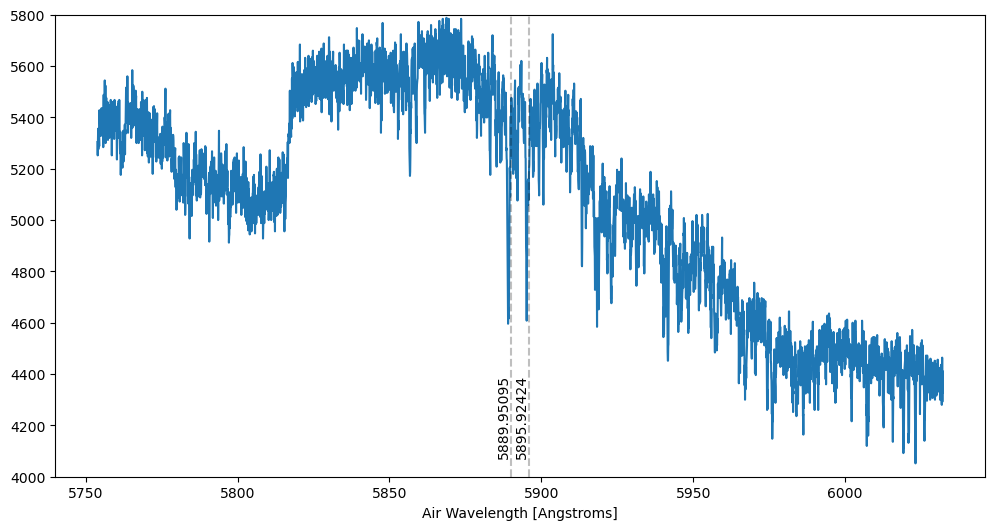

In [37]:
pl.figure(figsize=(12, 6))
pl.plot(wavelengths_refit, solar_image[1200,:])
pl.vlines(na_lines['Observed'], 4000, 6000, 'k', alpha=0.25, linestyle='--')
for wl in na_lines['Observed']:
    pl.text(wl, 4400, str(wl), rotation=90, ha='right', va='top')
pl.xlabel("Air Wavelength [Angstroms]");
pl.ylim([4000,5800]);

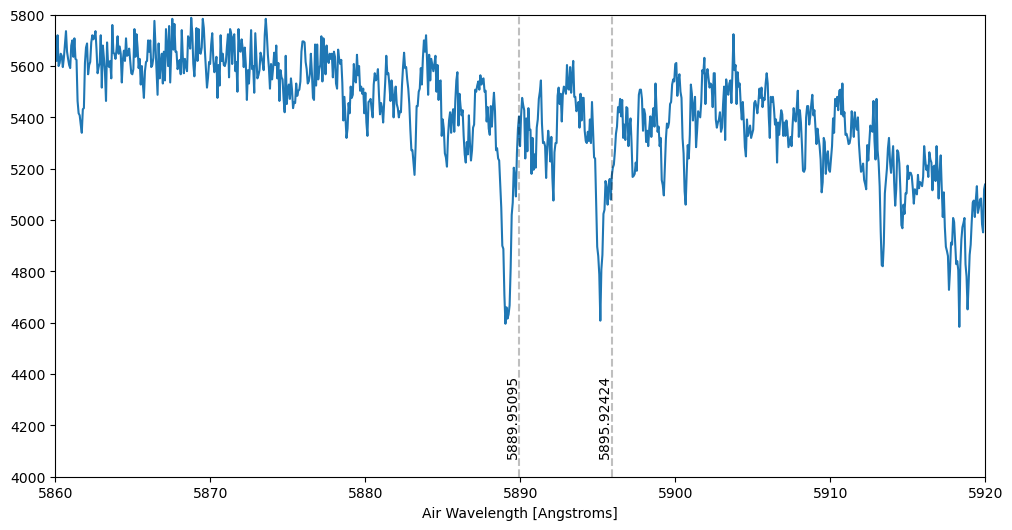

In [38]:
pl.figure(figsize=(12, 6))
pl.plot(wavelengths_refit, solar_image[1200,:])
pl.vlines(na_lines['Observed'], 4000, 6000, 'k', alpha=0.25, linestyle='--')
for wl in na_lines['Observed']:
    pl.text(wl, 4400, str(wl), rotation=90, ha='right', va='top')
pl.xlabel("Air Wavelength [Angstroms]");
pl.ylim([4000,5800]);
pl.xlim(5860,5920);

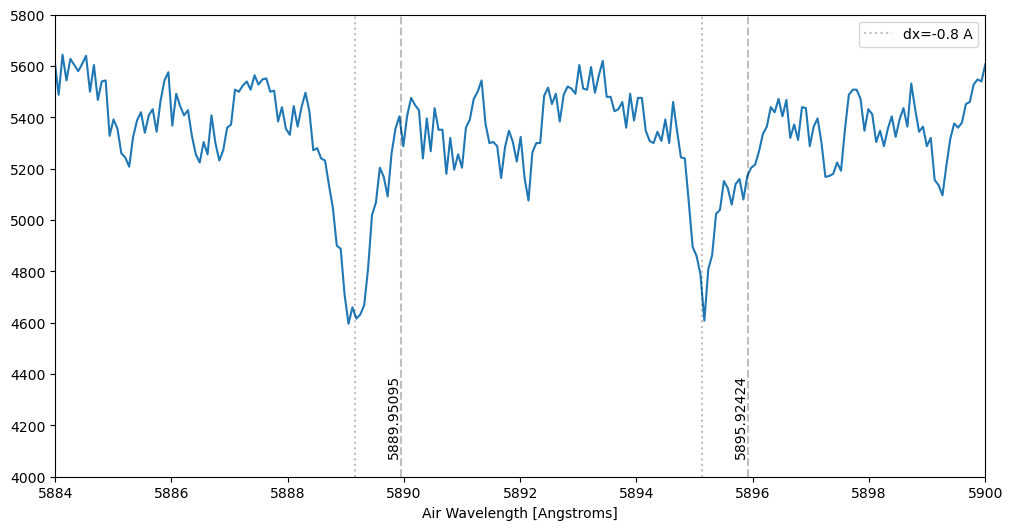

In [39]:
pl.figure(figsize=(12, 6))
pl.plot(wavelengths_refit, solar_image[1200,:])
pl.vlines(na_lines['Observed'], 4000, 6000, 'k', alpha=0.25, linestyle='--')
pl.vlines(na_lines['Observed'] - 0.8, 4000, 6000, 'k', alpha=0.25, linestyle=':', label='dx=-0.8 A')
for wl in na_lines['Observed']:
    pl.text(wl, 4400, str(wl), rotation=90, ha='right', va='top')
pl.xlabel("Air Wavelength [Angstroms]");
pl.legend(loc='best');
pl.ylim([4000,5800]);
pl.xlim(5884,5900);

In [40]:
0.8/5889 * 3e5

40.75394803871625

# Re-fit the lines for spectra obtained at different spatial locations


We have a long-slit spectrograph (that's what it's called even if the slit isn't all that long), which produces a 2D spectrum.  We want to know the wavelength at any position in the image.

## Approach 1: Naive

Can we just repeat the above approach to obtain a wavelength solution everywhere?

The process we'll try to follow is:

1. Select a vertical slice of the image where there is signal (where we detect the emission lines from our calibration lamp)
2. Using our guesses based on our single-spectrum solution above, compute the moment-1 (intensity-weighted average position) position of the spectral lines.
3. Fit a 2D polynomial to those data.

### Calculate the moment-1 positions

We iterate over each pixel between 200 and 2100 vertically and re-do the moment-measuring steps above.

In [233]:
npixels = 25 # we're jumping up to 25 pixels because there's a lot of curvature
ypix = np.arange(200, 2100)
pix_meas_grid = np.zeros([len(ypix), len(ne_pixel_vals)])
medsub_ne_image = ne_image - np.median(ne_image)
def posify_weights(weights):
    return weights * (weights > 0)
for ii, row in enumerate(ypix):
    weights = [posify_weights(medsub_ne_image[row, g-npixels:g+npixels])
               for g in map(int, ne_pixel_vals)]
    improved_xval_guesses_ne = [np.average(xaxis[g-npixels:g+npixels],
                                        weights=wt)
                                if wt.sum() > 500 # try for a signal threshold
                                else g
                             for g, wt in zip(map(int, ne_pixel_vals), weights)
                               ]
    pix_meas_grid[ii, :] = improved_xval_guesses_ne

Then, we overplot the result:

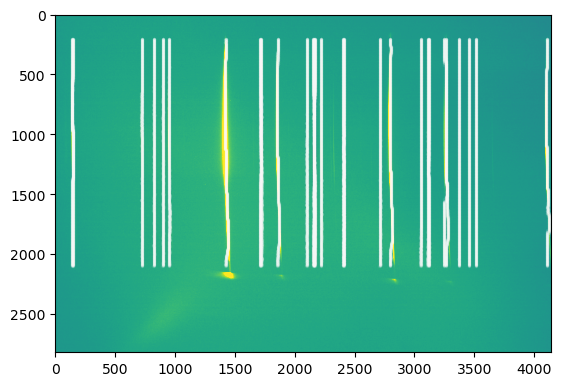

In [234]:
pl.imshow(ne_image, vmax=2200)
pl.scatter(pix_meas_grid, ypix[:,None]*np.ones_like(pix_meas_grid), marker='x', color='w', alpha=0.1, s=2);

To see this better, we can zoom in on two lines:

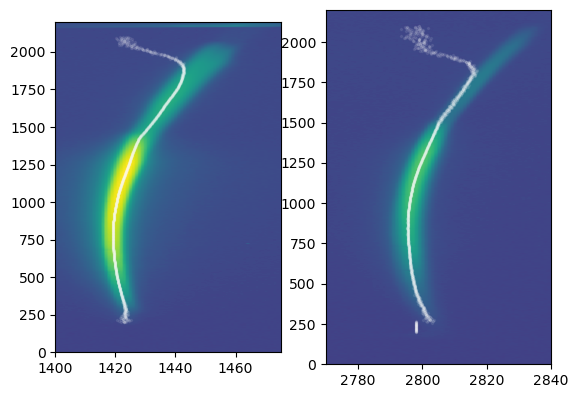

In [235]:
pl.subplot(1,2,1)
pl.imshow(ne_image, norm=simple_norm(ne_image, stretch='log'))
pl.scatter(pix_meas_grid, ypix[:,None]*np.ones_like(pix_meas_grid), marker='x', color='w', alpha=0.1, s=2)
pl.axis([1400,1475,0,2200]);
pl.gca().set_aspect(0.05);
pl.subplot(1,2,2)
pl.imshow(ne_image, norm=simple_norm(ne_image, stretch='log'))
pl.scatter(pix_meas_grid, ypix[:,None]*np.ones_like(pix_meas_grid), marker='x', color='w', alpha=0.1, s=2)
pl.axis([2770,2840,0,2200]);
pl.gca().set_aspect(0.05);

and now we see that it did OK but not great, especially at the top.  Part of the problem is that the lines curve too much.

### Something a little more sophisticated: use the previous answer to guess an offset

In [392]:
npixels = 15 # back to 15 pixels so we don't run into a neighbor

# make a list that starts at 1200
ypix = np.concatenate([np.arange(1200, 1950), np.arange(1200, 200, -1)])
pix_meas_grid = np.zeros([len(ypix), len(ne_pixel_vals)], dtype='float')

for ii, row in enumerate(ypix):
    if row == 1200:
        # fill in a starting point based on what we did above
        ne_pixel_vals_row = ne_pixel_vals
    else:
        # use the previous solution
        ne_pixel_vals_row = pix_meas_grid[ii-1]
    weights = [posify_weights(medsub_ne_image[row, g-npixels:g+npixels])
               for g in map(int, ne_pixel_vals_row)]
    improved_xval_guesses_ne = [np.average(xaxis[g-npixels:g+npixels], weights=wt)
                                if wt.sum() > 500 # try for a signal threshold
                                else -999
                             for g, wt in zip(map(int, ne_pixel_vals_row), weights)
                               ]
    pix_meas_grid[ii, :] = improved_xval_guesses_ne
pix_meas_grid[pix_meas_grid == -999] = np.nan

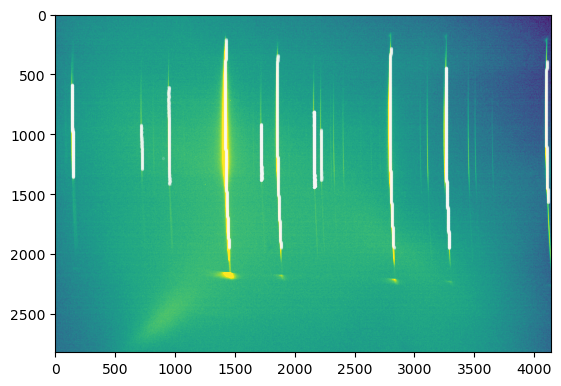

In [393]:
pl.imshow(ne_image_medsub, norm=simple_norm(ne_image_medsub, stretch='asinh', max_percent=99, min_percent=1))
pl.scatter(pix_meas_grid, ypix[:,None]*np.ones_like(pix_meas_grid), marker='x', color='w', alpha=0.1, s=2);

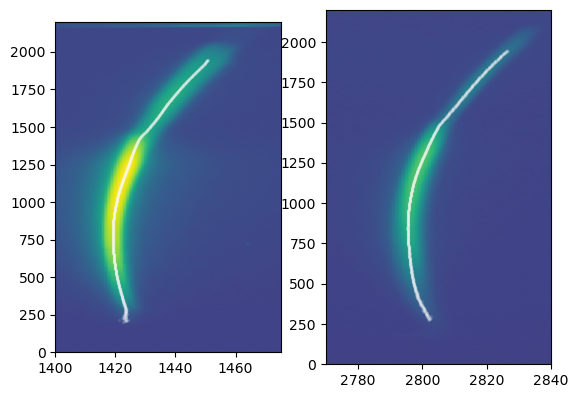

In [394]:
pl.subplot(1,2,1)
pl.imshow(ne_image, norm=simple_norm(ne_image, stretch='log'))
pl.scatter(pix_meas_grid, ypix[:,None]*np.ones_like(pix_meas_grid), marker='x', color='w', alpha=0.1, s=2)
pl.axis([1400,1475,0,2200]);
pl.gca().set_aspect(0.05);
pl.subplot(1,2,2)
pl.imshow(ne_image, norm=simple_norm(ne_image, stretch='log'))
pl.scatter(pix_meas_grid, ypix[:,None]*np.ones_like(pix_meas_grid), marker='x', color='w', alpha=0.1, s=2)
pl.axis([2770,2840,0,2200]);
pl.gca().set_aspect(0.05);

## Fit a 2D polynomial to our measurements

In [395]:
from astropy.modeling.polynomial import Polynomial2D

In [396]:
# construct 2D grid of wavelengths: we just repeat the wavelength for each Y-value, and repeat the Y-value for each X-position
wl_2d = ne_wl_final[None, :] * np.ones(len(ypix))[:, None]
ypix_2d = ypix[:, None] * np.ones_like(wl_2d).value
wl_2d, ypix_2d, wl_2d.shape, ypix_2d.shape

(<Quantity [[5764.0525, 5764.4188, 5804.4496, ..., 5987.9074, 5991.6477,
             6029.9968],
            [5764.0525, 5764.4188, 5804.4496, ..., 5987.9074, 5991.6477,
             6029.9968],
            [5764.0525, 5764.4188, 5804.4496, ..., 5987.9074, 5991.6477,
             6029.9968],
            ...,
            [5764.0525, 5764.4188, 5804.4496, ..., 5987.9074, 5991.6477,
             6029.9968],
            [5764.0525, 5764.4188, 5804.4496, ..., 5987.9074, 5991.6477,
             6029.9968],
            [5764.0525, 5764.4188, 5804.4496, ..., 5987.9074, 5991.6477,
             6029.9968]] Angstrom>,
 array([[1200., 1200., 1200., ..., 1200., 1200., 1200.],
        [1201., 1201., 1201., ..., 1201., 1201., 1201.],
        [1202., 1202., 1202., ..., 1202., 1202., 1202.],
        ...,
        [ 203.,  203.,  203., ...,  203.,  203.,  203.],
        [ 202.,  202.,  202., ...,  202.,  202.,  202.],
        [ 201.,  201.,  201., ...,  201.,  201.,  201.]]),
 (1750, 28),
 (1750, 28))

The shape above indicates that there are 1900 Y-pixel values in the fit (from 200 to 2100) and 28 wavelengths.

In [397]:
poly2d = Polynomial2D(degree=2)

fitted_polymodel_2d = linfitter(poly2d, np.nan_to_num(pix_meas_grid[:, :]), ypix_2d[:, :], wl_2d[:, :].value, weights=np.isfinite(pix_meas_grid[:, :]))
inverse_polymodel_2d = linfitter(poly2d, wl_2d[:, :].value, ypix_2d[:, :], np.nan_to_num(pix_meas_grid[:, :]), weights=np.isfinite(pix_meas_grid[:, :]))
fitted_polymodel_2d, inverse_polymodel_2d

(<Polynomial2D(2, c0_0=5753.44008323, c1_0=0.07019572, c2_0=-0.00000074, c0_1=0.00233324, c0_2=-0.00000154, c1_1=0.00000002)>,
 <Polynomial2D(2, c0_0=-85462.98409095, c1_0=14.8494954, c2_0=0., c0_1=-0.33914391, c0_2=0.00001619, c1_1=0.00005299)>)

In [398]:
inverse_polymodel_2d(wl_2d.value, ypix_2d)

array([[ 113.20977929,  118.67244997,  715.65601167, ..., 3451.58170139,
        3507.3611946 , 4079.26542025],
       [ 113.21493231,  118.6776224 ,  715.66330532, ..., 3451.59871643,
        3507.37840784, 4079.2846656 ],
       [ 113.22011769,  118.6828272 ,  715.67063134, ..., 3451.61576384,
        3507.39565345, 4079.30394332],
       ...,
       [ 124.17672171,  129.62004046,  724.48874202, ..., 3450.72220506,
        3506.30409514, 4076.18230624],
       [ 124.20387461,  129.64717395,  724.51375429, ..., 3450.73749593,
        3506.31918782, 4076.19536681],
       [ 124.23105988,  129.67433981,  724.53879893, ..., 3450.75281918,
        3506.33431287, 4076.20845975]])

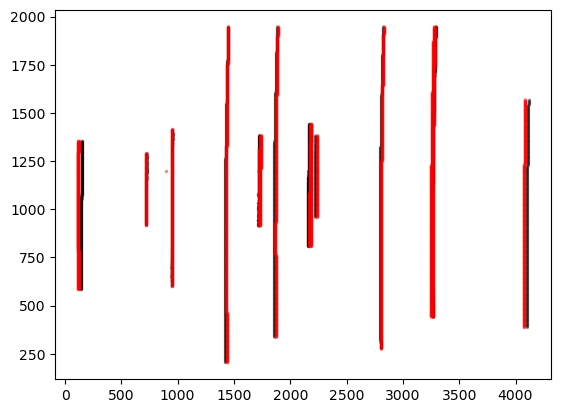

In [399]:
pl.scatter(pix_meas_grid, ypix[:,None]*np.ones_like(pix_meas_grid), marker='x', color='k', alpha=0.1, s=2);
pl.scatter(inverse_polymodel_2d(wl_2d.value, ypix_2d)[np.isfinite(pix_meas_grid)], ypix_2d[np.isfinite(pix_meas_grid)], marker= ',', color='r', s=1, alpha=0.1)

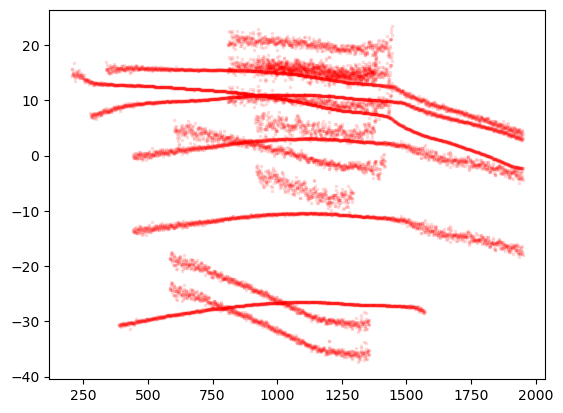

In [400]:
pl.scatter(ypix_2d[np.isfinite(pix_meas_grid)],
           inverse_polymodel_2d(wl_2d.value, ypix_2d)[np.isfinite(pix_meas_grid)] - pix_meas_grid[np.isfinite(pix_meas_grid)],
           marker= ',', color='r', s=1, alpha=0.1)

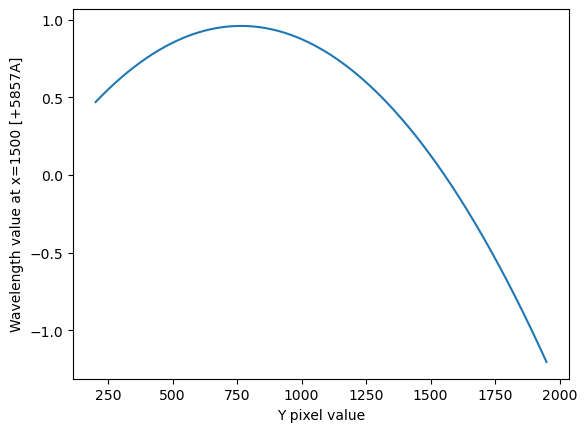

In [349]:
pl.plot(sorted(ypix), fitted_polymodel_2d(1500, sorted(ypix)) - 5857)
pl.xlabel("Y pixel value")
pl.ylabel("Wavelength value at x=1500 [+5857A]");

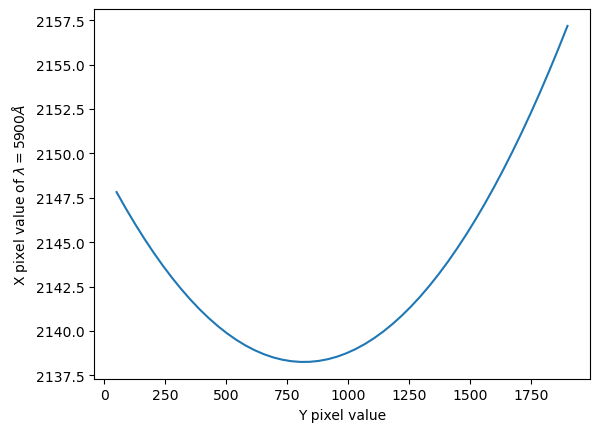

In [350]:
pl.plot(np.linspace(50, 1900), inverse_polymodel_2d(5900, np.linspace(50, 1900)));
pl.xlabel("Y pixel value")
pl.ylabel(r"X pixel value of $\lambda=5900\AA$");

In [351]:
yy, xx = np.indices(ne_image.shape)
wavelength_map = inverse_polymodel_2d(np.linspace(minwave.value, maxwave.value, ne_image.shape[1]), yy)

In [352]:
from scipy import ndimage

In [353]:
yy.min(), yy.max(), wavelength_map.min(), wavelength_map.max(), ne_image.shape

(0, 2821, -36.80771410716351, 4189.097250923074, (2822, 4144))

In [354]:
ne_image_medsub = ne_image - np.median(ne_image)
remap = ndimage.map_coordinates(ne_image_medsub, [yy, wavelength_map],)

In [355]:
remap.min(), remap.max()

(-190.2270936891502, 64524.474674625446)

In [356]:
from astropy.visualization import simple_norm

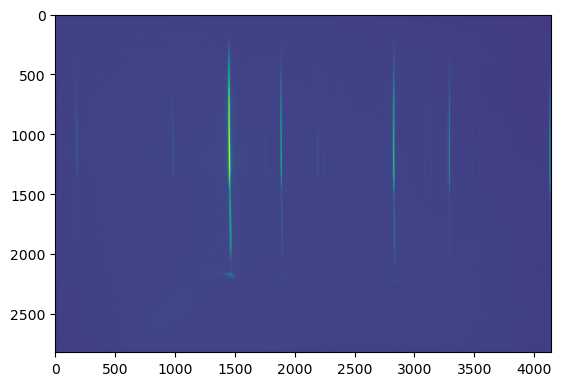

In [357]:
pl.imshow(remap, norm=simple_norm(remap, stretch='log'))

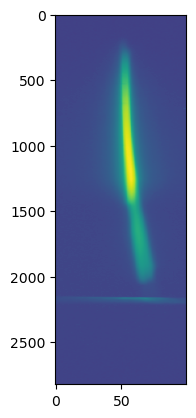

In [358]:
pl.imshow(remap[:,1400:1500], norm=simple_norm(remap, stretch='log'))
pl.gca().set_aspect(0.1)

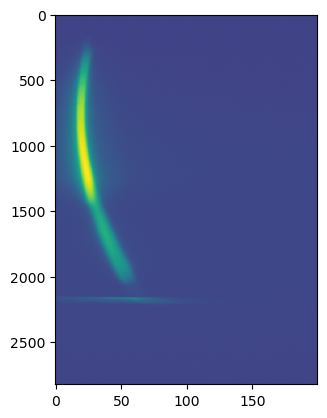

In [359]:
pl.imshow(ne_image_medsub[:,1400:1600], norm=simple_norm(ne_image_medsub, stretch='log'))
pl.gca().set_aspect(0.1)

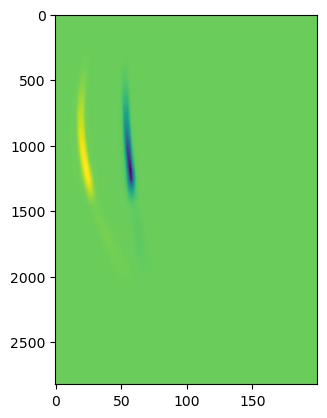

In [322]:
pl.imshow((ne_image_medsub-remap)[:,1400:1600], norm=simple_norm(ne_image_medsub-remap, stretch='asinh'))
pl.gca().set_aspect(0.1)

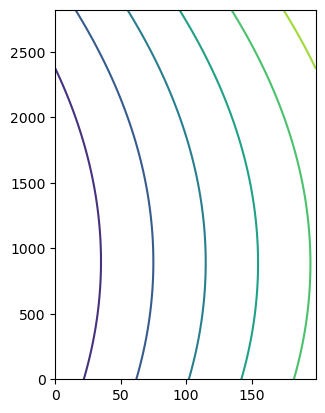

In [323]:
pl.contour(wavelength_map[:,1400:1600])
pl.gca().set_aspect(0.1)

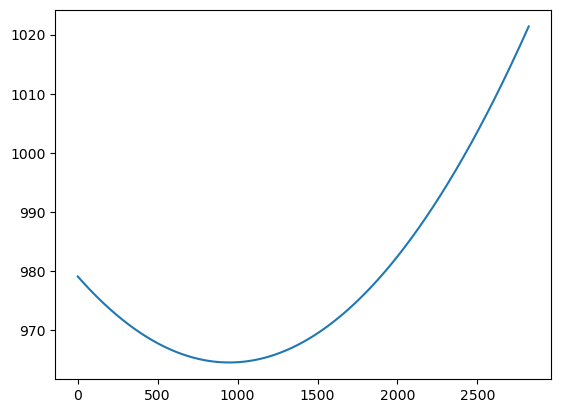

In [324]:
pl.plot(wavelength_map[:,1000])

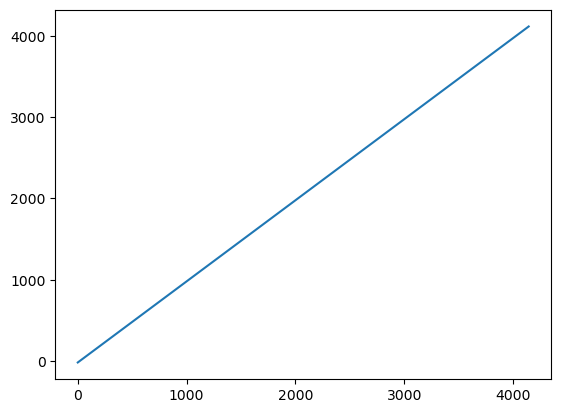

In [325]:
pl.plot(wavelength_map[0,:])

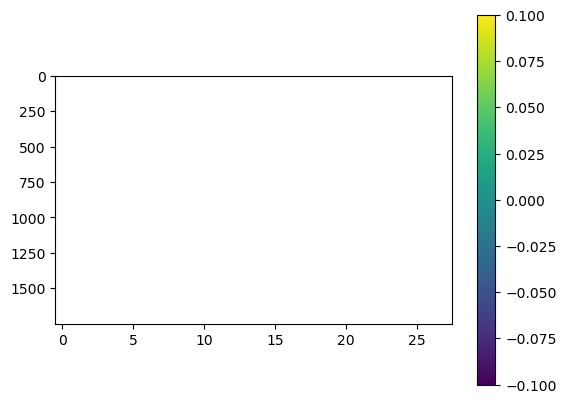

In [326]:
pl.imshow(pix_meas_grid-pix_meas_grid.mean(axis=0))
pl.gca().set_aspect(0.01);
pl.colorbar();

In [139]:

he_lines = Nist.query(minwav=5700*u.AA,
                        maxwav=6500*u.AA,
                        linename='He I')
he_keep = np.array([('*' not in x) and ('h' not in x) and ('-' not in x) for x in he_lines['Rel.']])
he_wl_tbl = he_lines['Observed'][he_keep]
he_rel_tbl = np.array([float(x) for x in he_lines['Rel.'][he_keep]])

/var/folders/k_/7qh4l0nn72b7qgq15pkd4hw40000gt/T/ipykernel_60360/2602321554.py:6: UserWarning: Warning: converting a masked element to nan.
  he_rel_tbl = np.array([float(x) for x in he_lines['Rel.'][he_keep]])


In [423]:
from skimage.morphology import skeletonize
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.filters import meijering, sato, frangi, hessian

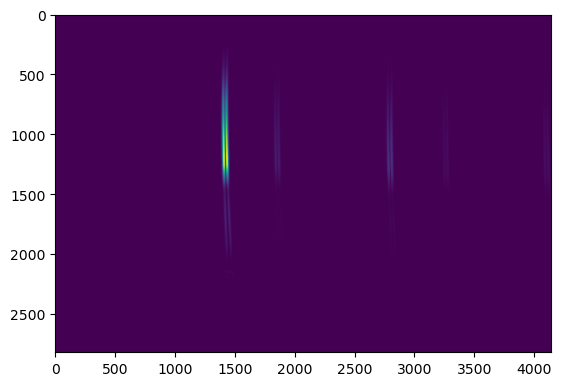

In [424]:
ne_meijering = meijering(ne_image)
pl.imshow(ne_meijering)

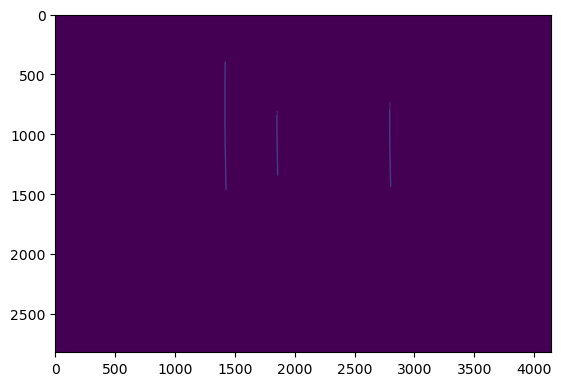

In [421]:
ne_canny = canny(ne_image, sigma=0.1)
pl.imshow(ne_canny)

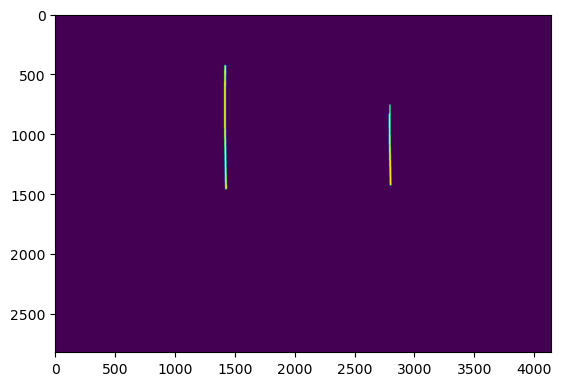

In [418]:
pl.imshow(ndimage.binary_dilation(ne_canny, iterations=5))